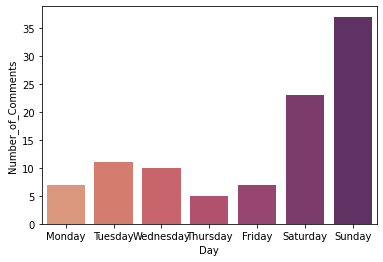

In [2]:
import requests
import datetime as dt
import calendar
import pandas
import seaborn as sns
import json


def get_pushshift_data(data_type, **kwargs):
    """
    Gets reddit data from the pushshift API (instead of 
    the reddit API because pushshift provides much more search results).
    
    Data_type can be 'comment' or 'submission'
    
    Read more: https://github.com/pushshift/api
    """
    
    base_url = f"https://api.pushshift.io/reddit/search/{data_type}/"
    params = kwargs
    request = requests.get(base_url, params)
    return request.json()


# Set up search terms:

data_type = "comment"  # Give me comments
subreddit = "dating_advice"
query = "lonely"  # Add my search term
duration = "30d"   # Integer + "s,m,h,d" (i.e. "second", "minute", "hour", "day")
size = 5000       # Maximum no. of comments
sort_type = "score"  # Options: "score", "num_comments", "created_utc"
sort = "desc"     # Sort descending


# Make the Pushshift API call:

json_data = get_pushshift_data(data_type=data_type, 
                               q=query,
                               subreddit=subreddit,
                               after=duration, 
                               size=size,
                               )


def get_date(unicodedate):
    """
    Converts unicode date to readable date format
    """
    return dt.datetime.fromtimestamp(unicodedate)


# Isolate the data dictionary values we want:

json_posts = json_data["data"]
all_relevant_post_details = [(post["subreddit"], post["created_utc"]) for post in json_posts]

# Put in pandas dataframe:

posts_dataframe = pandas.DataFrame(all_relevant_post_details)

# Give the columns names:

posts_dataframe.columns = ["Subreddit", "unicodedate"]

# Convert the unicode timestamp to a readable one, put in new column, split it to show only the date:

_timestamp = posts_dataframe["unicodedate"].apply(get_date)
posts_dataframe = posts_dataframe.assign(timestamp=_timestamp)
posts_dataframe["Date"] = [d.date() for d in posts_dataframe["timestamp"]]
del posts_dataframe["unicodedate"]
del posts_dataframe["timestamp"]

# Convert the new Date column to display the weekday:

day_names = [calendar.day_name[each.weekday()] for each in posts_dataframe["Date"]]
posts_dataframe["Day"] = day_names

# Add a column with just number 1s to count up the number of comments:

_number_of_comments = [1] * len(posts_dataframe["Date"])
posts_dataframe["Number_of_Comments"] = _number_of_comments

# Sort and group by day of the week:

categorical_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
grouped_by_day = posts_dataframe.groupby("Day")["Number_of_Comments"].count().reindex(categorical_order) 

# Plot the data:

graph = sns.barplot(x="Day",
                    y="Number_of_Comments", 
                    data=grouped_by_day.reset_index(), 
                    palette="flare"
                    )

